In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import DenseNet121 #Densenet121 모델 사용
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

# GPU 동작 확인

In [2]:
tensorflow.test.is_built_with_cuda()

True

In [3]:
tensorflow.test.is_built_with_gpu_support()

True

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7502416890983740520
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4177330176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1730233824904857309
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [5]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(48, 48, 3)) #채널이 무조건 3개여야 하며 크기는 최소 32 이상

x=model_d.output

x= GlobalAveragePooling2D()(x) #전역 평균 풀링 레이어 추가
x= BatchNormalization()(x) #배치 정규화 레이어
x= Dropout(0.5)(x)
#Fully Connected 레이어 추가
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x) #과적합 감소용 드롭아웃 레이어

preds=Dense(6,activation='softmax')(x) #FC-layer. 클래스가 7개이므로 softmax 7개 설정

In [7]:
model=Model(inputs=model_d.input,outputs=preds) 
model.summary() #모델 요약

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [8]:
#Freeze
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) #모델 생성
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_1_conv (Conv2D)    (None, 6, 6, 128)    28672       conv3_block4_0_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_bn (BatchNormali (None, 6, 6, 128)    512         conv3_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, 6, 6, 128)    0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, 6, 6, 32)     36864       conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_concat (Concatenat (None, 6, 6, 256)    0           conv3_block3_concat[0][0]        
          

In [10]:
data=[] #데이터
labels=[] #라벨
random.seed(42)
imagePaths = sorted(list(os.listdir("emotion_FixedVer/"))) #데이터셋 경로
random.shuffle(imagePaths) #셔플
print(imagePaths)
#이미지 읽기 및 라벨링
for img in imagePaths:
    path=sorted(list(os.listdir("emotion_FixedVer/"+img)))
    for i in path:
        image = cv2.imread("emotion_FixedVer/"+img+'/'+i) #이미지 읽기
        image = cv2.resize(image, (48,48)) #이미지 사이즈 편집
        image = img_to_array(image) #이미지 배열화
        data.append(image) #data 배열에 데이터 추가
        l = label = img
        labels.append(l) #labels 배열에 데이터 추가

['neutral', 'fearful', 'happy', 'sad', 'angry', 'surprised']


In [11]:
data = np.array(data, dtype="float32") / 255.0 #데이터 타입 변경 및 numpy 배열화
labels = np.array(labels) #라벨 numpy 배열화
mlb = LabelBinarizer() #데이터 전처리(원핫인코딩)
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [12]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42) #train용과 test용으로 데이터셋 분리
print(xtrain.shape, xtest.shape)

(16720, 48, 48, 3) (11148, 48, 48, 3)


In [13]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [14]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3) #학습률 조정
checkpoint = ModelCheckpoint('Densenet121_emotion6ver.h5', verbose=1, save_best_only=True) #체크포인트를 두고 모델 저장

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)


datagen.fit(xtrain)
# 모델 학습
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=64),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=150,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/150
130/130 - 29s - loss: 2.2872 - accuracy: 0.2736 - val_loss: 1.5913 - val_accuracy: 0.3685

Epoch 00001: val_loss improved from inf to 1.59134, saving model to Densenet121_emotion6ver.h5
Epoch 2/150
130/130 - 19s - loss: 1.8762 - accuracy: 0.3081 - val_loss: 1.5204 - val_accuracy: 0.3943

Epoch 00002: val_loss improved from 1.59134 to 1.52041, saving model to Densenet121_emotion6ver.h5
Epoch 3/150
130/130 - 19s - loss: 1.7036 - accuracy: 0.3440 - val_loss: 1.4951 - val_accuracy: 0.4124

Epoch 00003: val_loss improved from 1.52041 to 1.49513, saving model to Densenet121_emotion6ver.h5
Epoch 4/150
130/130 - 18s - loss: 1.6449 - accuracy: 0.3522 - val_loss: 1.4626 - val_accuracy: 0.4218

Epoch 00004: val_loss improved from 1.49513 to 1.46262, saving model to Densenet121_emotion6ver.h5
Epoch 5/150
130/130 - 18s - loss: 1.6137 - accuracy: 0.3535 - val_loss: 1.4991 - val_accuracy: 0.4168

Epoch 00005: val_loss did not improve from 1.46262
Epoch 6/150
130/130 - 18s - loss: 1.5884 -

Epoch 46/150
130/130 - 18s - loss: 1.4193 - accuracy: 0.4416 - val_loss: 1.2713 - val_accuracy: 0.5150

Epoch 00046: val_loss improved from 1.27215 to 1.27128, saving model to Densenet121_emotion6ver.h5
Epoch 47/150
130/130 - 18s - loss: 1.4122 - accuracy: 0.4468 - val_loss: 1.2722 - val_accuracy: 0.5185

Epoch 00047: val_loss did not improve from 1.27128
Epoch 48/150
130/130 - 18s - loss: 1.4096 - accuracy: 0.4467 - val_loss: 1.2698 - val_accuracy: 0.5144

Epoch 00048: val_loss improved from 1.27128 to 1.26982, saving model to Densenet121_emotion6ver.h5
Epoch 49/150
130/130 - 19s - loss: 1.4255 - accuracy: 0.4364 - val_loss: 1.2600 - val_accuracy: 0.5223

Epoch 00049: val_loss improved from 1.26982 to 1.26002, saving model to Densenet121_emotion6ver.h5
Epoch 50/150
130/130 - 18s - loss: 1.4074 - accuracy: 0.4520 - val_loss: 1.2515 - val_accuracy: 0.5221

Epoch 00050: val_loss improved from 1.26002 to 1.25146, saving model to Densenet121_emotion6ver.h5
Epoch 51/150
130/130 - 18s - loss


Epoch 00090: val_loss improved from 1.09550 to 1.09170, saving model to Densenet121_emotion6ver.h5
Epoch 91/150
130/130 - 18s - loss: 1.2844 - accuracy: 0.5023 - val_loss: 1.0934 - val_accuracy: 0.5966

Epoch 00091: val_loss did not improve from 1.09170
Epoch 92/150
130/130 - 17s - loss: 1.2809 - accuracy: 0.5091 - val_loss: 1.0872 - val_accuracy: 0.6015

Epoch 00092: val_loss improved from 1.09170 to 1.08719, saving model to Densenet121_emotion6ver.h5
Epoch 93/150
130/130 - 18s - loss: 1.2762 - accuracy: 0.5010 - val_loss: 1.0725 - val_accuracy: 0.6043

Epoch 00093: val_loss improved from 1.08719 to 1.07249, saving model to Densenet121_emotion6ver.h5
Epoch 94/150
130/130 - 18s - loss: 1.2941 - accuracy: 0.4988 - val_loss: 1.0825 - val_accuracy: 0.6072

Epoch 00094: val_loss did not improve from 1.07249
Epoch 95/150
130/130 - 18s - loss: 1.2917 - accuracy: 0.5036 - val_loss: 1.0784 - val_accuracy: 0.6085

Epoch 00095: val_loss did not improve from 1.07249
Epoch 96/150
130/130 - 17s - 


Epoch 00136: val_loss improved from 0.94824 to 0.94821, saving model to Densenet121_emotion6ver.h5
Epoch 137/150
130/130 - 17s - loss: 1.1921 - accuracy: 0.5475 - val_loss: 0.9424 - val_accuracy: 0.6664

Epoch 00137: val_loss improved from 0.94821 to 0.94238, saving model to Densenet121_emotion6ver.h5
Epoch 138/150
130/130 - 18s - loss: 1.1948 - accuracy: 0.5429 - val_loss: 0.9384 - val_accuracy: 0.6699

Epoch 00138: val_loss improved from 0.94238 to 0.93842, saving model to Densenet121_emotion6ver.h5
Epoch 139/150
130/130 - 18s - loss: 1.1959 - accuracy: 0.5389 - val_loss: 0.9381 - val_accuracy: 0.6744

Epoch 00139: val_loss improved from 0.93842 to 0.93813, saving model to Densenet121_emotion6ver.h5
Epoch 140/150
130/130 - 18s - loss: 1.1890 - accuracy: 0.5474 - val_loss: 0.9371 - val_accuracy: 0.6722

Epoch 00140: val_loss improved from 0.93813 to 0.93708, saving model to Densenet121_emotion6ver.h5
Epoch 141/150
130/130 - 18s - loss: 1.1870 - accuracy: 0.5522 - val_loss: 0.9267 - v

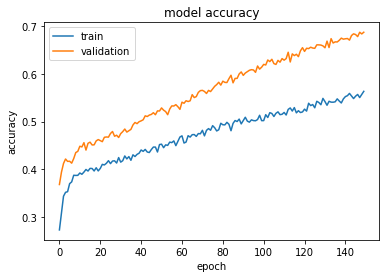

In [15]:
plot_hist(history)

In [16]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 11148 	accurately-predicted-data: 5285 	 wrongly-predicted-data:  5863
Accuracy: 47.408 %
